In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
%matplotlib inline
mapping, inv_mapping = [], []

def generate_triples(N, total):
    # List containing generated triples
    gen = []

    
    if 0 <= total <= N - 1:
        # Generate first element
        i, j, k = (0, 0, total)
        while i <= total:
            # print ("now i is", i)
            while j <= total - i:
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            j = 0
            k = total - i
            
                # pass

    elif N <= total <= 2*N - 3:
        # Generate first element
        i, j, k = (0, total-N+1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k


            
    elif 2*N - 2 <= total <= 3*N - 3:
        # Generate first element
        i, j, k = (total - 2*N + 2, N-1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k
        
    else:
        raise ValueError("Not applicable k")

    return gen

def index_triple_maps(N):
    mapping = {}
    inv_mapping = {}
    for k in range(3*N - 2):
        triples = generate_triples(N, k)
        coords = OrderedDict()
        inv_coords = OrderedDict()
        for i in range(len(triples)):
            coords[i] = triples[i]
            inv_coords[triples[i]] = i
        mapping[k] = coords
        inv_mapping[k] = inv_coords
    return mapping, inv_mapping

def omit_sites(inv_mapping, omit):    
    site = 0
    new_inv_map = {}
    new_map = {}
    
    for sum_ in inv_mapping.keys():
        inv_sum_k_sites = OrderedDict()
        sum_k_sites = OrderedDict()
        site_index = 0
        for triple in inv_mapping[sum_].keys():
            if omit[site] == 1:
                inv_sum_k_sites[triple] = site_index
                sum_k_sites[site_index] = triple
                site_index += 1
            else:
                x, y, z = triple
#                 print ("I'm omitting", triple)
            site += 1
        new_inv_map[sum_] = inv_sum_k_sites
        new_map[sum_] = sum_k_sites

    return new_map, new_inv_map, x, y, z

def _calculate(z_n, x_, y_, z_, x_o, y_o, z_o, t_n = 1.0, e_n = 1.0, N = 20, k = 1, c = complex,
                           mapping = mapping, inv_mapping = inv_mapping):

    

    amplitude = t_n / (z_n - e_n)
    # amplitude = 1
    a = {}
    b = {}


    for k in range(3*N-2):
        alpha_num_entries = len(inv_mapping[k-1]) if k > 0 else 0
        my_entries = len(inv_mapping[k])
        beta_num_entries = len(inv_mapping[k+1]) if k < 3*N - 3 else 0
        a_k = np.zeros((my_entries, alpha_num_entries), dtype=c)
        b_k = np.zeros((my_entries, beta_num_entries), dtype=c)
        for index, triple in mapping[k].items():
            x, y, z = triple

            # Calculate b_k
            if k < 3*N - 3:
                if x < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x + 1, y, z]] = amplitude
                    except:
                        pass
                    
                if y < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y + 1, z]] = amplitude
                    except:
                        pass

                if z < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y, z + 1]] = amplitude
                    except:
                        pass
#             # Calculate a_k
            if 0 < k:
                if x > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x - 1, y, z]] = amplitude
                    except:
                        pass

                if y > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y - 1, z]] = amplitude
                    except:
                        pass

                if z > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y, z - 1]] = amplitude
                    except:
                        pass

        a[k] = a_k
        b[k] = b_k

    # Calculate C
    sum_ = sum([x_, y_, z_])
    
    C = np.zeros(shape = (len(inv_mapping[sum_]), 1), dtype = complex)
    C[inv_mapping[sum_][(x_, y_, z_)]] = 1. / (z_n - e_n)
    
        



    # Calculate Multiplicative Factors 
    A = {}
    G = {}
    A[1] = b[1]
    
    for k in range(2, sum_):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), b[k])


    A[3*N - 4] = a[3*N - 4]
    for k in range(3*N - 5, sum_, -1):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), a[k])

    
    # Calculate Green's Functions
    V = OrderedDict()
    k = sum_
    if 1 < k < 3*N-4:
        V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]) - b[k].dot(A[k + 1]), 
                            C)
    elif k == 1:
        V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), 
                            C)
    elif k == 3*N - 4:
        V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), 
                            C)
            
    
    # if x_t + y_t + z_t > sum_:
    for k in range(sum_ + 1, 3*N - 3):
        V[k] = A[k].dot(V[k - 1])
    # elif x_t + y_t + z_t < sum_:
    for k in range(sum_ - 1, 0, -1):
        V[k] = A[k].dot(V[k + 1])

    # return V[x_t + y_t + z_t]
    return V

In [ ]:
def gen_triples(N):
    i, j, k = (0, 0, 0)
    coords = []
    for i in range(N):
        for j in range(N):
            for k in range(N):
                coords.append((i,j,k))

    return coords
coords = gen_triples(N)
ordered_mapping = {i: coords[i] for i in range(len(coords))}
ordered_inv_mapping = {coords[i]: i for i in range(len(coords))}
ordered_inv_mapping

In [2]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


# with open('true_first.pickle', 'rb') as handle:
#     true_Y = pickle.load(handle, encoding='latin1')
    
# with open('pred_first.pickle', 'rb') as handle:
#     pred_Y_1 = pickle.load(handle, encoding='latin1')
# with open('true_second.pickle', 'rb') as handle:
#     true_Y_2 = pickle.load(handle, encoding='latin1')
# with open('pred_second.pickle', 'rb') as handle:
#     pred_Y_2 = pickle.load(handle, encoding='latin1')

# def merge_two_dicts(x, y):
#     z = x.copy()   # start with x's keys and values
#     z.update(y)    # modifies z with y's keys and values & returns None
#     return z

# pred_Y = merge_two_dicts(pred_Y_1, pred_Y_2)
# del pred_Y_1
# del pred_Y_2

In [4]:
greenfs["true_value"]

array([-0.04149459-0.44200314j])

In [54]:
x_, y_, z_ = (5, 5, 5)
with open('greenfs-5-5-5.pickle', 'rb') as handle:
    greenfs = pickle.load(handle, encoding='latin1')
error = OrderedDict()
for omit in greenfs["predicted_value"].keys():
    error[omit] = np.absolute(greenfs["predicted_value"][omit] - greenfs["true_value"])
import operator
as_index, me = zip(*sorted(error.items(), key = lambda x: np.absolute(operator.itemgetter(1)(x)))[:9000])
print ("threshold", me[-1])
# print(as_index)
as_index = list(as_index)
energy = 0.8
N=25
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[as_index] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
# print (_inv_mapping)
# raise ValueError

# Do not omit target and destination states
# if (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
#     continue
if (x_ + y_ + z_ == 3*N - 3) or (x_ + y_ + z_ == 0):
    raise ValueError

# if _ % 100 == 10:
#     print (x_, y_, z_, x_o, y_o, z_o, energy)

true_v = greenfs["true_value"]
predicted_value = (_calculate(energy+0.1j, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
predicted_value = predicted_value[sum([x_, y_, z_])][_inv_mapping[sum([x_, y_, z_])][(x_, y_, z_)]]
#     print("true_list", true_list)
#     print("pred_list", pred_list)
print ("predicted_value", predicted_value, "abs", np.absolute(predicted_value))
print ("true_value", true_v, "abs", np.absolute(true_v))
print ("Absolute error", np.absolute(predicted_value - true_v ))
print ("Relative error", np.absolute(predicted_value - true_v )/np.absolute(true_v))

threshold [9.81392692e-05]
predicted_value [-0.03860945-0.43894544j] abs [0.4406402]
true_value [-0.04149459-0.44200314j] abs [0.4439466]
Absolute error [0.004204]
Relative error [0.0094696]


In [49]:
# N=25
# mapping, inv_mapping = index_triple_maps(N)
# omit = np.full(N**3, 1)
# omit[10] = 0
# _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
# print("(5, 5, 5)", _inv_mapping[15][(5, 5, 5)])
# true_v = true_Y[1000][15][_inv_mapping[15][(5, 5, 5)]]
# pred_v = []
# v_index = []
# for i in pred_Y.keys():
#     omit = np.full(N**3, 1)
#     omit[i] = 0
#     _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
# #     print ("Omitting", x_o, y_o, z_o)
#     v_index.append(_inv_mapping[15][(5, 5, 5)]) 
#     pred_v.append(pred_Y[i][15][_inv_mapping[15][(5, 5, 5)]])
# #     print (pred_v, true_v)
# #     break
# pred_v = np.array(pred_v)
# er = np.log10(np.absolute(pred_v - true_v)/np.absolute(true_v))
# er = er[er > -100]
# plt.hist(er, 40)
# as_index = np.argsort(np.absolute(pred_v - true_v).flatten())[:4000]
# print(as_index[:10])
# as_index[as_index >= 755] += 1
# print(as_index[:10])
as_index = list(as_index)
energy = 0.8
N=25
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[as_index] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
x_, y_, z_ = (5, 5, 5)
# print (_inv_mapping)
# raise ValueError

# Do not omit target and destination states
# if (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
#     continue
if (x_ + y_ + z_ == 3*N - 3) or (x_ + y_ + z_ == 0):
    raise ValueError

# if _ % 100 == 10:
#     print (x_, y_, z_, x_o, y_o, z_o, energy)

true_v = greenfs["true_value"]
predicted_value = (_calculate(energy+0.1j, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
predicted_value = predicted_value[15][_inv_mapping[15][(5,5,5)]]
#     print("true_list", true_list)
#     print("pred_list", pred_list)
print ("predicted_value", predicted_value, "abs", np.absolute(predicted_value))
print ("true_value", true_v, "abs", np.absolute(true_v))
print ("Absolute error", np.absolute(predicted_value - true_v ))
print ("Relative error", np.absolute(predicted_value - true_v )/np.absolute(true_v))

predicted_value [-0.04147268-0.4420326j] abs [0.44397388]
true_value [-0.04149459-0.44200314j] abs [0.4439466]
Absolute error [3.67115944e-05]
Relative error [8.26937174e-05]


(5, 6, 4) 76


/Users/alng/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


[   0 7997 2936 1555 5509 3099 2917 2818 3105 5729]
[   0 7999 2938 1557 5511 3101 2919 2820 3107 5731]
(5, 6, 4) 62
predicted_value [-0.02172215+0.04606118j] abs [0.05092627]
true_value [-0.01735549+0.07279795j] abs [0.07483819]
Absolute error [0.02709101]
Relative error [0.36199439]


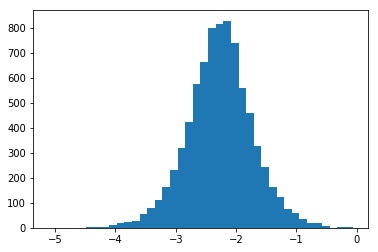

In [49]:
N=20
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[10] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
print("(5, 6, 4)", _inv_mapping[15][(5, 6, 4)])
true_v = true_Y[1000][15][_inv_mapping[15][(5, 6, 4)]]
pred_v = []
v_index = []
for i in pred_Y.keys():
    if coord_map[i] == (5,6,4):
        continue
    omit = np.full(N**3, 1)
    omit[i] = 0
    _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
#     print ("Omitting", x_o, y_o, z_o)
    v_index.append(_inv_mapping[15][(5, 6, 4)]) 
    pred_v.append(pred_Y[i][15][_inv_mapping[15][(5, 6, 4)]])
#     print (pred_v, true_v)
#     break
pred_v = np.array(pred_v)
er = np.log10(np.absolute(pred_v - true_v)/np.absolute(true_v))
er = er[er > -100]
plt.hist(er, 40)
as_index = np.argsort(np.absolute(pred_v - true_v).flatten())[:4000]
print(as_index[:10])
as_index[as_index >= 755] += 2
print(as_index[:10])
energy = 0.8
N=20
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[as_index] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
x_, y_, z_ = (5, 5, 5)
# print (_inv_mapping)
# raise ValueError

# Do not omit target and destination states
# if (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
#     continue
if (x_ + y_ + z_ == 3*N - 3) or (x_ + y_ + z_ == 0):
    raise ValueError

# if _ % 100 == 10:
#     print (x_, y_, z_, x_o, y_o, z_o, energy)


predicted_value = (_calculate(energy+0.1j, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
print("(5, 6, 4)", _inv_mapping[15][(5, 6, 4)])
predicted_value = predicted_value[15][_inv_mapping[15][(5, 6, 4)]]
#     print("true_list", true_list)
#     print("pred_list", pred_list)
print ("predicted_value", predicted_value, "abs", np.absolute(predicted_value))
print ("true_value", true_v, "abs", np.absolute(true_v))
print ("Absolute error", np.absolute(predicted_value - true_v ))
print ("Relative error", np.absolute(predicted_value - true_v )/np.absolute(true_v))

(5, 7, 3) 77


/Users/alng/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


[   0 7997 5651 2818 4928 2936 3528 3105 2917 5644]
[   0 7999 5653 2820 4930 2938 3530 3107 2919 5646]
(5, 7, 3) 60
predicted_value [-0.02069869+0.00884652j] abs [0.02250992]
true_value [0.0001982+0.01114247j] abs [0.01114424]
Absolute error [0.02102264]
Relative error [1.88641351]


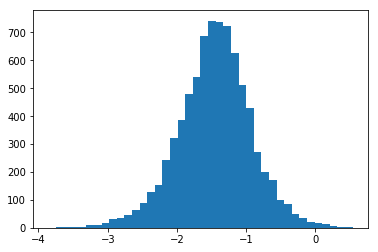

In [51]:
N=20
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[10] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
print("(5, 7, 3)", _inv_mapping[15][(5, 7, 3)])
true_v = true_Y[0][15][_inv_mapping[15][(5, 7, 3)]]
pred_v = []
v_index = []
for i in pred_Y.keys():
    if coord_map[i] == (5, 7, 3):
        continue
    omit = np.full(N**3, 1)
    omit[i] = 0
    _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
#     print ("Omitting", x_o, y_o, z_o)
    v_index.append(_inv_mapping[15][(5, 7, 3)]) 
    pred_v.append(pred_Y[i][15][_inv_mapping[15][(5, 7, 3)]])
#     print (pred_v, true_v)
#     break
pred_v = np.array(pred_v)
er = np.log10(np.absolute(pred_v - true_v)/np.absolute(true_v))
er = er[er > -100]
plt.hist(er, 40)
as_index = np.argsort(np.absolute(pred_v - true_v).flatten())[:4000]
print(as_index[:10])
as_index[as_index >= 755] += 1
as_index[as_index >= 756] += 1
print(as_index[:10])
energy = 0.8
N=20
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[as_index] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
x_, y_, z_ = (5, 5, 5)
# print (_inv_mapping)
# raise ValueError

# Do not omit target and destination states
# if (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
#     continue
if (x_ + y_ + z_ == 3*N - 3) or (x_ + y_ + z_ == 0):
    raise ValueError

# if _ % 100 == 10:
#     print (x_, y_, z_, x_o, y_o, z_o, energy)


predicted_value = (_calculate(energy+0.1j, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
print("(5, 7, 3)", _inv_mapping[15][(5, 7, 3)])
predicted_value = predicted_value[15][_inv_mapping[15][(5, 7, 3)]]
#     print("true_list", true_list)
#     print("pred_list", pred_list)
print ("predicted_value", predicted_value, "abs", np.absolute(predicted_value))
print ("true_value", true_v, "abs", np.absolute(true_v))
print ("Absolute error", np.absolute(predicted_value - true_v ))
print ("Relative error", np.absolute(predicted_value - true_v )/np.absolute(true_v))

In [44]:
N=20
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[10] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
[true_Y[i][15][_inv_mapping[15][(5, 6, 4)]] for i in true_Y.keys()]

[array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+0.07279795j]),
 array([-0.01735549+

In [ ]:
N=20
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[10] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
print("(5, 4, 6)", _inv_mapping[15][(5, 4, 6)])
true_v = true_Y[1000][15][_inv_mapping[15][(5, 4, 6)]]
pred_v = []
v_index = []
for i in pred_Y.keys():
    if coord_map[i] == (5, 4, 6):
        continue
    omit = np.full(N**3, 1)
    omit[i] = 0
    _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
#     print ("Omitting", x_o, y_o, z_o)
    v_index.append(_inv_mapping[15][(5, 4, 6)]) 
    pred_v.append(pred_Y[i][15][_inv_mapping[15][(5, 4, 6)]])
#     print (pred_v, true_v)
#     break
pred_v = np.array(pred_v)
er = np.log10(np.absolute(pred_v - true_v)/np.absolute(true_v))
er = er[er > -100]
plt.hist(er, 40)
as_index = np.argsort(np.absolute(pred_v - true_v).flatten())[:4000]
print(as_index[:10])
as_index[as_index >= 754] += 2
print(as_index[:10])
energy = 0.8
N=20
mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[as_index] = 0
_mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
x_, y_, z_ = (5, 5, 5)
# print (_inv_mapping)
# raise ValueError

# Do not omit target and destination states
# if (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
#     continue
if (x_ + y_ + z_ == 3*N - 3) or (x_ + y_ + z_ == 0):
    raise ValueError

# if _ % 100 == 10:
#     print (x_, y_, z_, x_o, y_o, z_o, energy)


predicted_value = (_calculate(energy+0.1j, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
predicted_value = predicted_value[15][_inv_mapping[15][(5, 4, 6)]]
print("(5, 4, 6)", _inv_mapping[15][(5, 4, 6)])

#     print("true_list", true_list)
#     print("pred_list", pred_list)
print ("predicted_value", predicted_value, "abs", np.absolute(predicted_value))
print ("true_value", true_v, "abs", np.absolute(true_v))
print ("Absolute error", np.absolute(predicted_value - true_v ))
print ("Relative error", np.absolute(predicted_value - true_v )/np.absolute(true_v))

In [ ]:
tr = true_Y[40]
pr = pred_Y[40]
x = []
for k in tr:
    x.extend ((np.absolute(tr[k] - pr[k])) < 8e-4)
print ((np.array(x))[:100])

Omitting 1 13 3


In [20]:
x_, y_, z_ = (5, 5, 5)
N=20
mapping, inv_mapping = index_triple_maps(N)
energy_list = []
true_list = []
pred_list = []

for _ in range(500):
    
    energy =  np.random.uniform(-1, 1) 
    energy_list.append(energy)
    # x_, y_, z_ = np.random.randint(20, size=3)
    
    omit = np.full(N**3, 1)
    # for i in range(10):
        # omit[i] = 0
    omit[1000] = 0
    _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
    # print (_inv_mapping)
    # raise ValueError
    
    # Do not omit target and destination states
    if (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
        continue
    if (x_ + y_ + z_ == 3*N - 3) or (x_ + y_ + z_ == 0):
        continue
    if _ % 100 == 10:
        print (x_, y_, z_, x_o, y_o, z_o, energy)

    
    
    
    true_value = (_calculate(energy+0.1j, x_, y_, z_, x_o, y_o, z_o, mapping = mapping, inv_mapping = inv_mapping))
    true_list.append(true_value[25][inv_mapping[25][(10,7,8)]])
    # true_value = (_calculate(energy+0.1j, x_, y_, z_, 1, 1, 1, mapping = mapping, inv_mapping = inv_mapping))

    # Remove omitted state from true value for error calculation
#     if x_o + y_o + z_o in true_value.keys():
#         true_value[x_o + y_o + z_o] = np.delete(true_value[x_o + y_o + z_o], inv_mapping[x_o + y_o + z_o][(x_o, y_o, z_o)])
#         true_value[x_o + y_o + z_o] = true_value[x_o + y_o + z_o][:,np.newaxis]

    
    predicted_value = (_calculate(energy+0.1j, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
    pred_list.append(predicted_value[25][_inv_mapping[25][(10,7,8)]])
#     print("true_list", true_list)
#     print("pred_list", pred_list)
    
    

5 5 5 1 13 3 0.7417812518684836
5 5 5 1 13 3 -0.8844625726566395
5 5 5 1 13 3 0.49624097968446246
5 5 5 1 13 3 -0.4717927204735366
5 5 5 1 13 3 -0.17783767443095821


In [19]:
np.mean(true_list) # big value

(-0.10803499607047419-0.43835352797822663j)

In [8]:
true_list = np.array(true_list) 
pred_list = np.array(pred_list)
err = np.absolute(true_list - pred_list)

(0, 0.001)

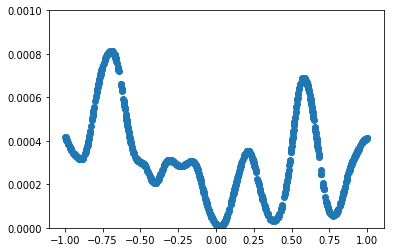

In [12]:
plt.scatter(energy_list, err)
plt.ylim(0, 1e-3)

(0, 0.0025)

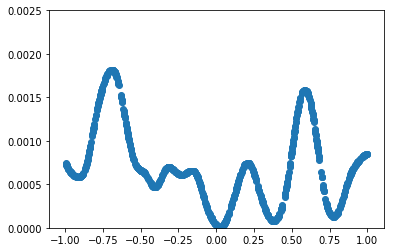

In [16]:
plt.scatter(energy_list, np.absolute(true_list - pred_list) / np.absolute(true_list))
plt.ylim(0, 2.5e-3)

In [ ]:
# Calculate error 
    # for k in true_value.keys():
        # relative error = modulus of error / modulus of true value
        # error = np.absolute((predicted_value[k] - true_value[k]) / true_value[k] * 100)
        # print ("I'm printing key ", k)
#         print ("I'm printing true_value")
#         print (true_value[k])
        # print ("I'm printing error")
#         print (predicted_value[k])
        # print (np.absolute(true_value[k] - predicted_value[k]) / np.absolute(true_value[k]))
        # for index, triple in enumerate(inv_mapping[k].keys()):
        #     (x, y, z) = triple
        #     x, y, z, x__, y__, z__, x_o_, y_o_, z_o_ = (np.array([x, y, z, x_, y_, z_, x_o, y_o, z_o], dtype=float) / 10.0) - 1
            # x, y, z, x__, y__, z__ = (np.array([x, y, z, x_, y_, z_], dtype=int)) 
        #     X.append([x, y, z, x__, y__, z__, energy])
        # print(true_value[k])
        # print(predicted_value[k])
        # true_Y.extend(true_value[k])
        # pred_Y.extend(predicted_value[k])
#     true_Y[_] = true_value
#     pred_Y[_] = predicted_value
    # print (len(X))

# print (true_Y)
# print (true_Y.keys())
# print (true_Y[1000].keys())
# print (pred_Y)
# import pickle
# with open('true_second.pickle', 'wb') as handle:
#     pickle.dump(true_Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('pred_second.pickle', 'wb') as handle:
#     pickle.dump(pred_Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

# true_Y = np.array(true_Y)
# pred_Y = np.array(pred_Y)
# X = np.array(X)
# np.save("predictors2" + str(energy), X)
# np.save("true", true_Y)
# np.save("pred", pred_Y)